# Confounder Analysis V2 - Full Results

Analysis of all 2700 generations (450 per model) using Haiku with async + prompt caching.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [3]:
# Load all results
df = pd.read_csv("../results/confounder_analysis_v2_full/all_analysis.csv")
print(f"Total samples: {len(df)}")
print(f"Columns: {list(df.columns)}")
df.head()

Total samples: 2700
Columns: ['model_size', 'strength', 'prompt', 'generation', 'sentiment_label', 'p_positive', 'coherence', 'is_refusal', 'has_ai_disclaimer', 'is_repetitive', 'has_hallucination', 'quality_tier', 'error']


,model_size,strength,prompt,generation,sentiment_label,p_positive,coherence,is_refusal,has_ai_disclaimer,is_repetitive,has_hallucination,quality_tier,error
0,0.6B,-0.5,Write a review of a restaurant you visited rec...,"I'm not a human, and I don't know what the ""re...",NEGATIVE,0.000187,1.0,True,True,True,False,poor,NaN
1,0.6B,-0.5,Write a review of a restaurant you visited rec...,"I’m not a human, and I don’t care about the co...",NEGATIVE,0.000244,0.0,False,False,True,True,broken,NaN
2,0.6B,-0.5,Write a review of a restaurant you visited rec...,"I can't be a person with no experience, and th...",NEGATIVE,0.000433,1.0,False,False,True,False,poor,NaN
3,0.6B,-0.5,Write a review of a restaurant you visited rec...,"I've been in a loop of complaining about the ""...",NEGATIVE,0.000309,1.0,False,False,True,False,poor,NaN
4,0.6B,-0.5,Write a review of a restaurant you visited rec...,I can't do this. I don't have the capacity to ...,NEGATIVE,0.001850,NaN,NaN,NaN,NaN,NaN,NaN,Max retries exceeded


In [4]:
# Check data quality
print("Samples by model size:")
print(df.groupby('model_size').size())

print("\nSamples with errors:")
print(df['error'].value_counts())

print(f"\nValid samples (no errors): {df['error'].isna().sum()}")
print(f"Failed samples: {df['error'].notna().sum()}")

Samples by model size:
model_size
0.6B    450
1.7B    450
14B     450
32B     450
4B      450
8B      450
dtype: int64

Samples with errors:
error
Max retries exceeded    1419
Name: count, dtype: int64

Valid samples (no errors): 1281
Failed samples: 1419


In [5]:
# Filter to valid samples
df_valid = df[df['error'].isna()].copy()
print(f"Valid samples: {len(df_valid)}")
print(f"\nBy model size:")
print(df_valid.groupby('model_size').size())

Valid samples: 1281

By model size:
model_size
0.6B    233
1.7B    213
14B     205
32B     211
4B      209
8B      210
dtype: int64


## Quality Tier Distribution

In [6]:
# Quality tier by model and strength
pivot_quality = pd.crosstab(
    [df_valid['model_size'], df_valid['strength']], 
    df_valid['quality_tier'], 
    normalize='index'
) * 100

print("Quality tier distribution (%) by model and steering strength:")
print(pivot_quality.round(1))

Quality tier distribution (%) by model and steering strength:
quality_tier         broken  excellent  good   poor
model_size strength                                
0.6B       -0.50       53.6        0.0   0.0   46.4
           -0.25        0.0        0.0  41.9   58.1
           -0.10        0.0        0.0  72.7   27.3
           -0.05        0.0        0.0  61.5   38.5
            0.00        0.0        0.0  76.2   23.8
            0.05        0.0        0.0  20.0   80.0
            0.10        0.0        0.0  16.2   83.8
            0.25        0.0        0.0   9.1   90.9
            0.50        0.0        0.0   0.0  100.0
1.7B       -0.50       20.0        0.0   0.0   80.0
           -0.25        0.0        0.0  63.6   36.4
           -0.10        0.0        0.0  88.5   11.5
           -0.05        0.0        0.0  68.0   32.0
            0.00        0.0        0.0  75.0   25.0
            0.05        0.0        0.0  37.9   62.1
            0.10        0.0        0.0  25.0   75.0
  

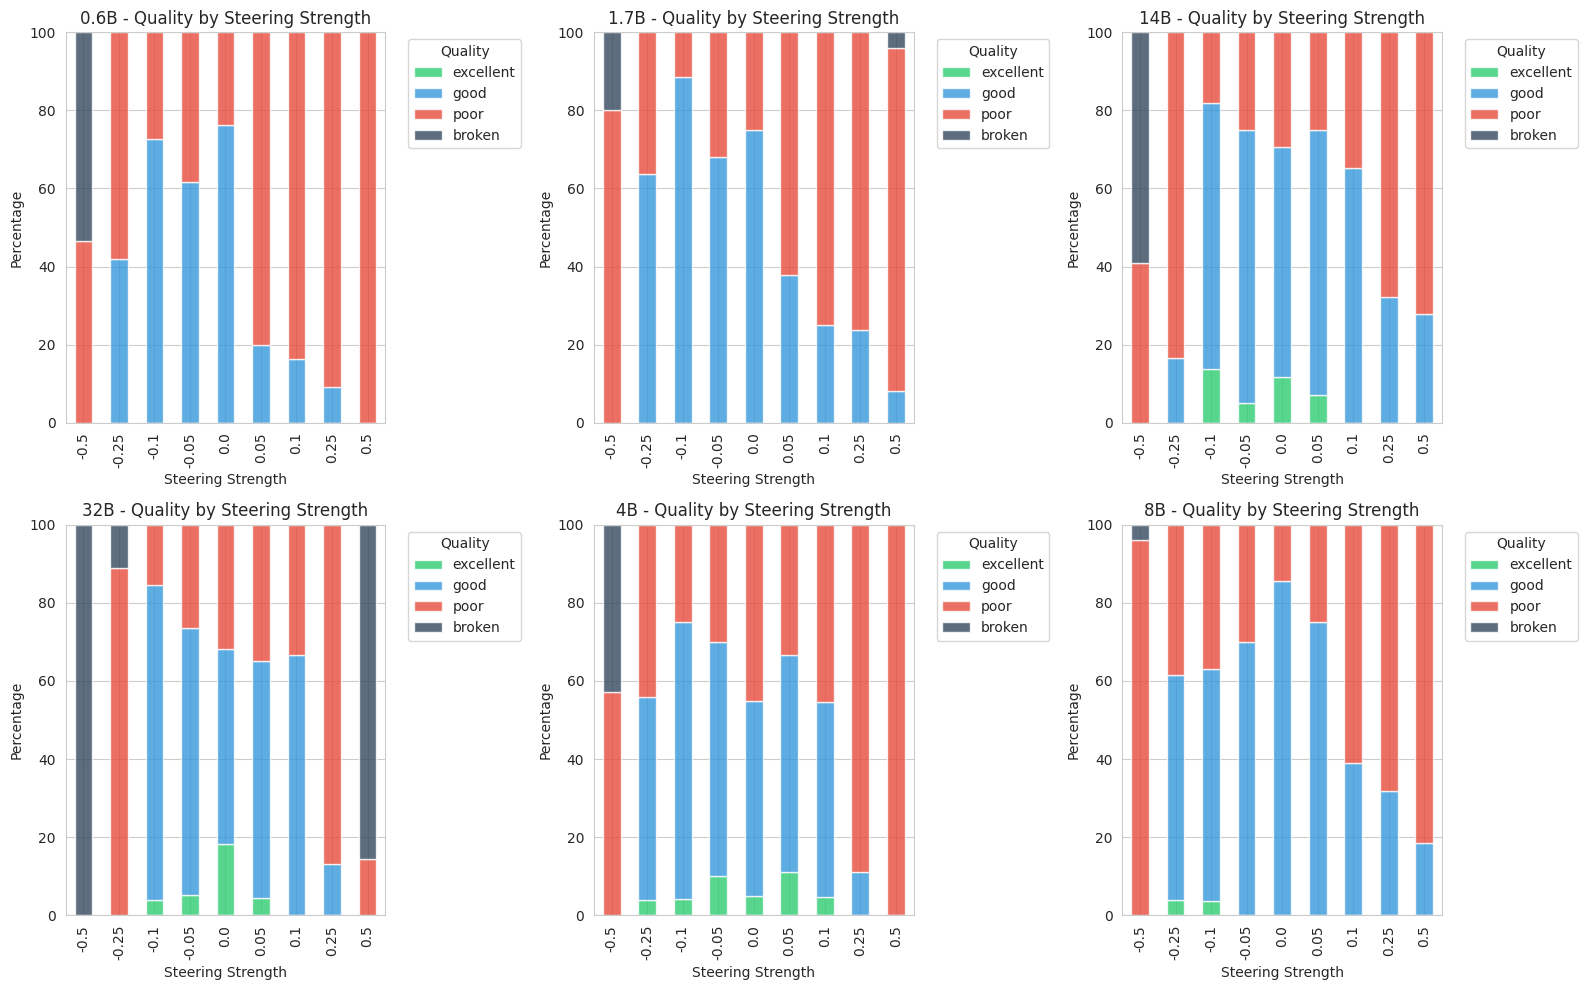

In [7]:
# Plot quality tier by steering strength
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

model_sizes = sorted(df_valid['model_size'].unique())
quality_order = ['excellent', 'good', 'poor', 'broken']

for idx, model_size in enumerate(model_sizes):
    model_df = df_valid[df_valid['model_size'] == model_size]
    
    # Calculate percentages
    quality_by_strength = pd.crosstab(
        model_df['strength'],
        model_df['quality_tier'],
        normalize='index'
    ) * 100
    
    # Ensure all quality tiers are present
    for tier in quality_order:
        if tier not in quality_by_strength.columns:
            quality_by_strength[tier] = 0
    
    quality_by_strength = quality_by_strength[quality_order]
    
    quality_by_strength.plot(
        kind='bar',
        stacked=True,
        ax=axes[idx],
        color=['#2ecc71', '#3498db', '#e74c3c', '#34495e'],
        alpha=0.8
    )
    
    axes[idx].set_title(f'{model_size} - Quality by Steering Strength')
    axes[idx].set_xlabel('Steering Strength')
    axes[idx].set_ylabel('Percentage')
    axes[idx].legend(title='Quality', bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[idx].set_ylim(0, 100)

plt.tight_layout()
plt.savefig('../results/confounder_analysis_v2_full/quality_by_strength.png', dpi=150, bbox_inches='tight')
plt.show()

## Coherence Analysis

In [8]:
# Coherence score by model and strength
coherence_stats = df_valid.groupby(['model_size', 'strength'])['coherence'].agg(['mean', 'std', 'count'])
print("Coherence statistics by model and strength:")
print(coherence_stats.round(2))

Coherence statistics by model and strength:
                     mean   std  count
model_size strength                   
0.6B       -0.50     0.46  0.51     28
           -0.25     1.45  0.51     31
           -0.10     1.82  0.39     22
           -0.05     1.73  0.45     26
            0.00     1.81  0.40     21
            0.05     1.76  0.44     25
            0.10     1.73  0.45     37
            0.25     1.82  0.39     22
            0.50     1.52  0.51     21
1.7B       -0.50     0.80  0.41     25
           -0.25     1.64  0.49     22
           -0.10     1.88  0.33     26
           -0.05     1.56  0.51     25
            0.00     1.70  0.47     20
            0.05     1.52  0.51     29
            0.10     1.50  0.51     20
            0.25     1.71  0.46     21
            0.50     1.20  0.50     25
14B        -0.50     0.41  0.50     22
           -0.25     1.21  0.41     24
           -0.10     1.77  0.43     22
           -0.05     1.80  0.41     20
            0.00    

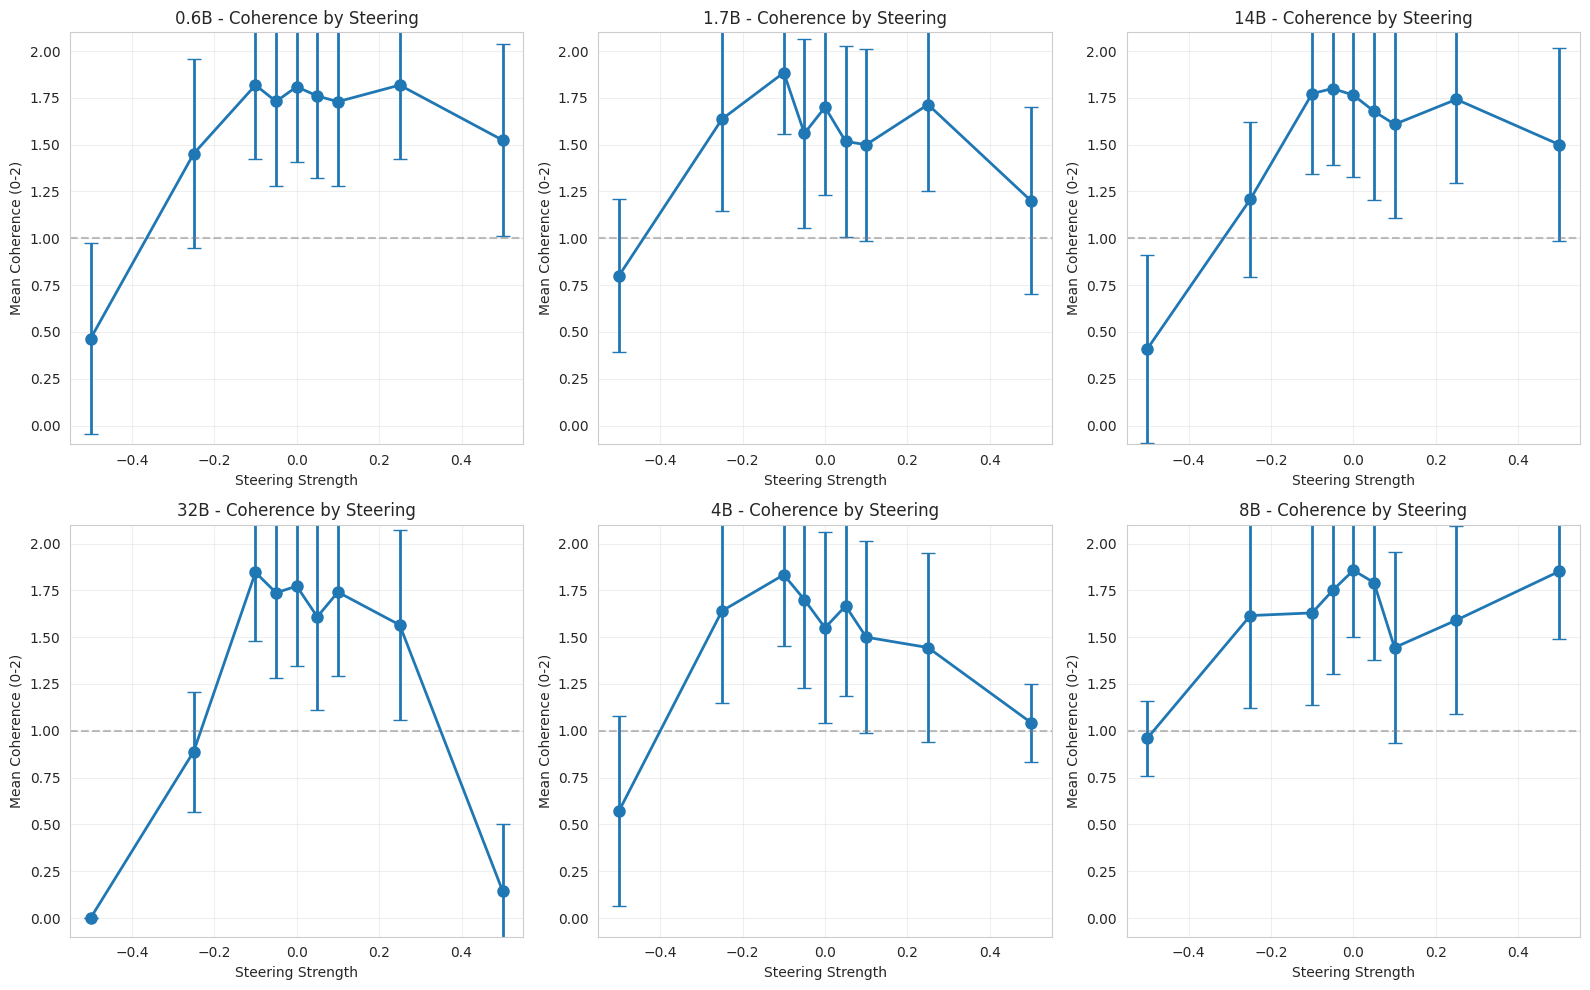

In [9]:
# Plot coherence by strength for each model
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, model_size in enumerate(model_sizes):
    model_df = df_valid[df_valid['model_size'] == model_size]
    
    coherence_by_strength = model_df.groupby('strength')['coherence'].agg(['mean', 'std', 'count'])
    
    axes[idx].errorbar(
        coherence_by_strength.index,
        coherence_by_strength['mean'],
        yerr=coherence_by_strength['std'],
        marker='o',
        capsize=5,
        linewidth=2,
        markersize=8
    )
    
    axes[idx].set_title(f'{model_size} - Coherence by Steering')
    axes[idx].set_xlabel('Steering Strength')
    axes[idx].set_ylabel('Mean Coherence (0-2)')
    axes[idx].set_ylim(-0.1, 2.1)
    axes[idx].axhline(y=1, color='gray', linestyle='--', alpha=0.5, label='Threshold')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/confounder_analysis_v2_full/coherence_by_strength.png', dpi=150, bbox_inches='tight')
plt.show()

## Confound Flags Analysis

In [11]:
# Analyze confound flags by strength
confound_flags = ['is_refusal', 'has_ai_disclaimer', 'is_repetitive', 'has_hallucination']

for flag in confound_flags:
    print(f"\n{flag.upper()}:")
    flag_by_strength = df_valid.groupby(['model_size', 'strength'])[flag].mean() * 100
    print(flag_by_strength)


IS_REFUSAL:
model_size  strength
0.6B        -0.50       21.428571
            -0.25       58.064516
            -0.10       40.909091
            -0.05       26.923077
             0.00       19.047619
             0.05             4.0
             0.10             0.0
             0.25             0.0
             0.50             0.0
1.7B        -0.50            12.0
            -0.25            50.0
            -0.10       26.923077
            -0.05             8.0
             0.00            15.0
             0.05        3.448276
             0.10            10.0
             0.25             0.0
             0.50             0.0
14B         -0.50       27.272727
            -0.25            75.0
            -0.10        9.090909
            -0.05            10.0
             0.00             0.0
             0.05        3.571429
             0.10        8.695652
             0.25             0.0
             0.50             0.0
32B         -0.50             0.0
            -0

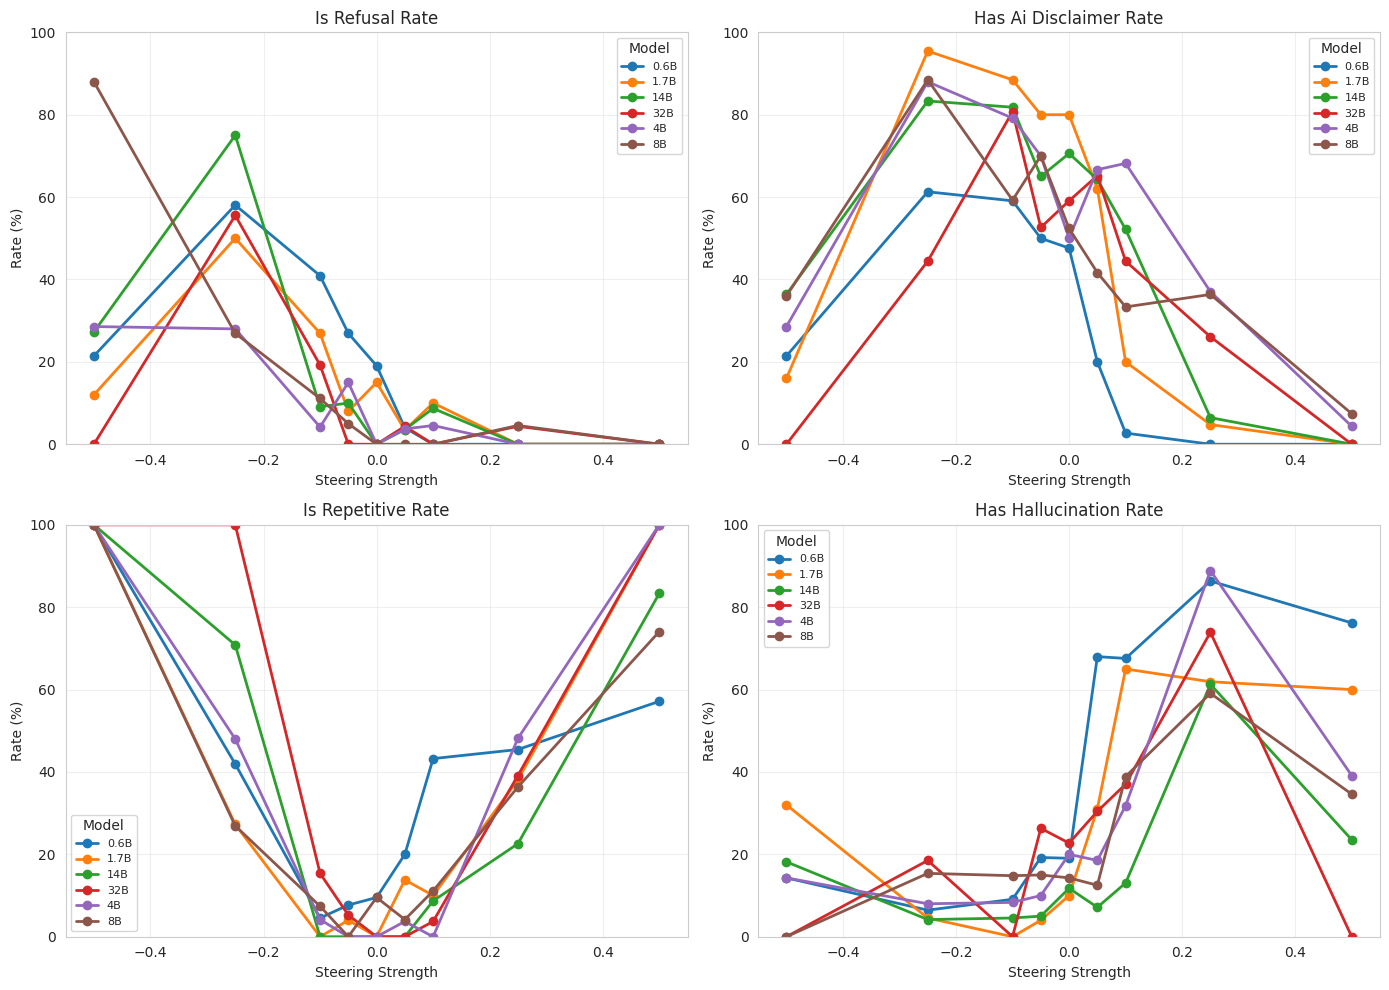

In [12]:
# Plot confound flags
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, flag in enumerate(confound_flags):
    for model_size in model_sizes:
        model_df = df_valid[df_valid['model_size'] == model_size]
        flag_rate = model_df.groupby('strength')[flag].mean() * 100
        
        axes[idx].plot(
            flag_rate.index,
            flag_rate.values,
            marker='o',
            label=model_size,
            linewidth=2,
            markersize=6
        )
    
    axes[idx].set_title(f'{flag.replace("_", " ").title()} Rate')
    axes[idx].set_xlabel('Steering Strength')
    axes[idx].set_ylabel('Rate (%)')
    axes[idx].legend(title='Model', fontsize=8)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_ylim(0, 100)

plt.tight_layout()
plt.savefig('../results/confounder_analysis_v2_full/confound_flags.png', dpi=150, bbox_inches='tight')
plt.show()

## Sentiment Analysis

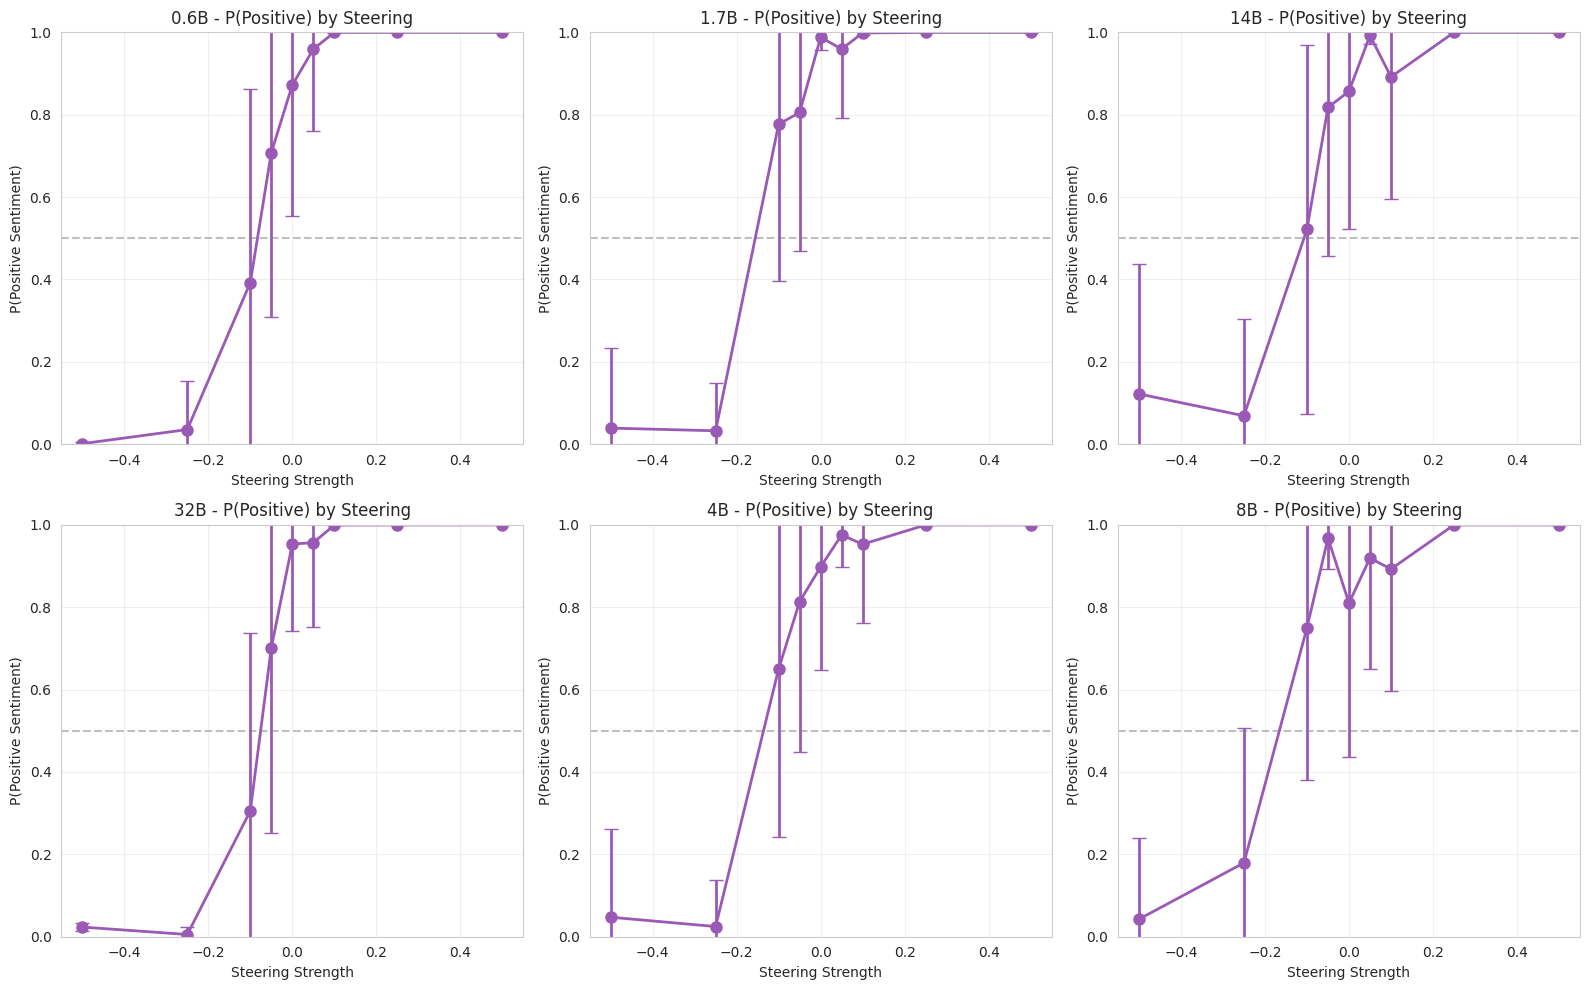

In [13]:
# Sentiment by steering strength
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, model_size in enumerate(model_sizes):
    model_df = df_valid[df_valid['model_size'] == model_size]
    
    # Mean p_positive by strength
    sentiment_by_strength = model_df.groupby('strength')['p_positive'].agg(['mean', 'std'])
    
    axes[idx].errorbar(
        sentiment_by_strength.index,
        sentiment_by_strength['mean'],
        yerr=sentiment_by_strength['std'],
        marker='o',
        capsize=5,
        linewidth=2,
        markersize=8,
        color='#9b59b6'
    )
    
    axes[idx].set_title(f'{model_size} - P(Positive) by Steering')
    axes[idx].set_xlabel('Steering Strength')
    axes[idx].set_ylabel('P(Positive Sentiment)')
    axes[idx].set_ylim(0, 1)
    axes[idx].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Neutral')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/confounder_analysis_v2_full/sentiment_by_strength.png', dpi=150, bbox_inches='tight')
plt.show()

## Cross-Model Comparison

In [14]:
# Compare metrics across models at baseline (strength=0)
baseline = df_valid[df_valid['strength'] == 0.0]

print("Baseline (strength=0) comparison:")
print("\nCoherence:")
print(baseline.groupby('model_size')['coherence'].mean().round(2))

print("\nP(Positive):")
print(baseline.groupby('model_size')['p_positive'].mean().round(3))

print("\nQuality tier distribution:")
quality_baseline = pd.crosstab(
    baseline['model_size'],
    baseline['quality_tier'],
    normalize='index'
) * 100
print(quality_baseline.round(1))

Baseline (strength=0) comparison:

Coherence:
model_size
0.6B    1.81
1.7B    1.70
14B     1.76
32B     1.77
4B      1.55
8B      1.86
Name: coherence, dtype: float64

P(Positive):
model_size
0.6B    0.872
1.7B    0.988
14B     0.857
32B     0.953
4B      0.898
8B      0.810
Name: p_positive, dtype: float64

Quality tier distribution:
quality_tier  excellent  good  poor
model_size                         
0.6B                0.0  76.2  23.8
1.7B                0.0  75.0  25.0
14B                11.8  58.8  29.4
32B                18.2  50.0  31.8
4B                  5.0  50.0  45.0
8B                  0.0  85.7  14.3


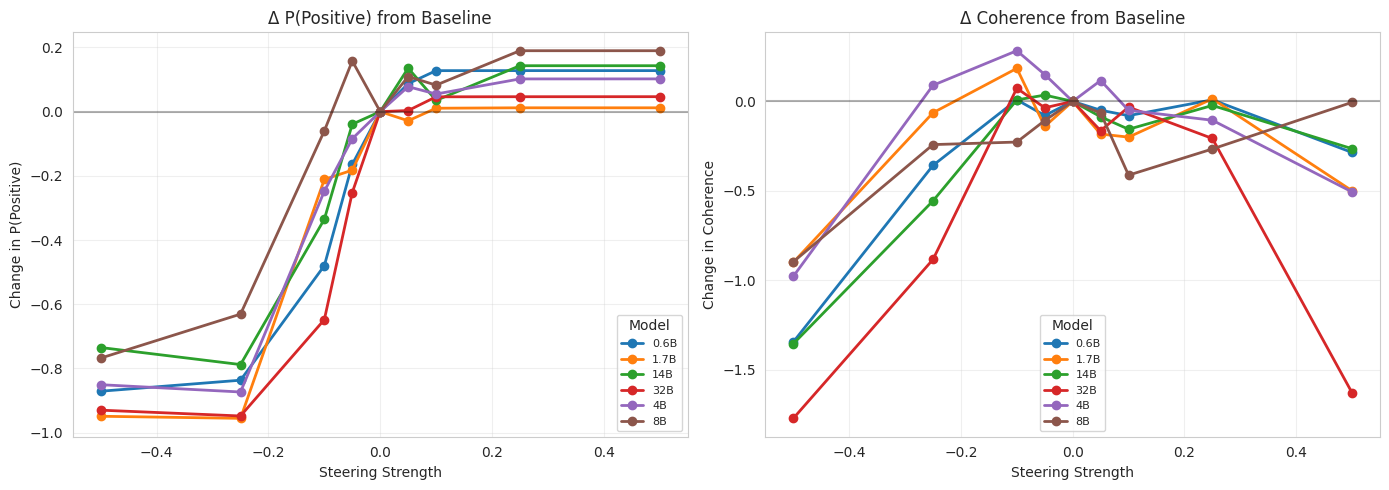

In [15]:
# Effect size: change from baseline
baseline_stats = df_valid[df_valid['strength'] == 0.0].groupby('model_size').agg({
    'p_positive': 'mean',
    'coherence': 'mean'
})

# Calculate deltas for each strength
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for model_size in model_sizes:
    model_df = df_valid[df_valid['model_size'] == model_size]
    baseline_p = baseline_stats.loc[model_size, 'p_positive']
    baseline_c = baseline_stats.loc[model_size, 'coherence']
    
    delta_sentiment = model_df.groupby('strength')['p_positive'].mean() - baseline_p
    delta_coherence = model_df.groupby('strength')['coherence'].mean() - baseline_c
    
    axes[0].plot(delta_sentiment.index, delta_sentiment.values, marker='o', label=model_size, linewidth=2)
    axes[1].plot(delta_coherence.index, delta_coherence.values, marker='o', label=model_size, linewidth=2)

axes[0].set_title('Δ P(Positive) from Baseline')
axes[0].set_xlabel('Steering Strength')
axes[0].set_ylabel('Change in P(Positive)')
axes[0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[0].legend(title='Model', fontsize=8)
axes[0].grid(True, alpha=0.3)

axes[1].set_title('Δ Coherence from Baseline')
axes[1].set_xlabel('Steering Strength')
axes[1].set_ylabel('Change in Coherence')
axes[1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[1].legend(title='Model', fontsize=8)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/confounder_analysis_v2_full/delta_from_baseline.png', dpi=150, bbox_inches='tight')
plt.show()

## Key Findings Summary

In [16]:
print("KEY FINDINGS:")
print("=" * 60)

# 1. Extreme negative steering effect
extreme_neg = df_valid[df_valid['strength'] == -0.5]
print("\n1. EXTREME NEGATIVE STEERING (strength=-0.5):")
print(f"   Broken outputs: {(extreme_neg['quality_tier'] == 'broken').mean() * 100:.1f}%")
print(f"   Mean coherence: {extreme_neg['coherence'].mean():.2f}")
print(f"   Refusal rate: {extreme_neg['is_refusal'].mean() * 100:.1f}%")

# 2. Extreme positive steering effect  
extreme_pos = df_valid[df_valid['strength'] == 0.5]
print("\n2. EXTREME POSITIVE STEERING (strength=0.5):")
print(f"   Poor/broken outputs: {((extreme_pos['quality_tier'] == 'poor') | (extreme_pos['quality_tier'] == 'broken')).mean() * 100:.1f}%")
print(f"   Repetitive: {extreme_pos['is_repetitive'].mean() * 100:.1f}%")
print(f"   Hallucination rate: {extreme_pos['has_hallucination'].mean() * 100:.1f}%")

# 3. Sentiment steering efficacy
print("\n3. SENTIMENT STEERING EFFICACY:")
for model_size in model_sizes:
    model_df = df_valid[df_valid['model_size'] == model_size]
    baseline_p = model_df[model_df['strength'] == 0.0]['p_positive'].mean()
    max_pos_p = model_df[model_df['strength'] == 0.5]['p_positive'].mean()
    max_neg_p = model_df[model_df['strength'] == -0.5]['p_positive'].mean()
    print(f"   {model_size}: baseline={baseline_p:.3f}, +0.5={max_pos_p:.3f} (Δ={max_pos_p-baseline_p:+.3f}), -0.5={max_neg_p:.3f} (Δ={max_neg_p-baseline_p:+.3f})")

# 4. Model scale effects
print("\n4. MODEL SCALE EFFECTS (at baseline):")
baseline = df_valid[df_valid['strength'] == 0.0]
for model_size in model_sizes:
    model_baseline = baseline[baseline['model_size'] == model_size]
    excellent_rate = (model_baseline['quality_tier'] == 'excellent').mean() * 100
    mean_coherence = model_baseline['coherence'].mean()
    print(f"   {model_size}: {excellent_rate:.1f}% excellent, coherence={mean_coherence:.2f}")

KEY FINDINGS:

1. EXTREME NEGATIVE STEERING (strength=-0.5):
   Broken outputs: 45.8%
   Mean coherence: 0.54
   Refusal rate: 29.9%

2. EXTREME POSITIVE STEERING (strength=0.5):
   Poor/broken outputs: 91.1%
   Repetitive: 85.9%
   Hallucination rate: 39.8%

3. SENTIMENT STEERING EFFICACY:
   0.6B: baseline=0.872, +0.5=1.000 (Δ=+0.128), -0.5=0.001 (Δ=-0.871)
   1.7B: baseline=0.988, +0.5=1.000 (Δ=+0.012), -0.5=0.039 (Δ=-0.949)
   14B: baseline=0.857, +0.5=1.000 (Δ=+0.143), -0.5=0.122 (Δ=-0.735)
   32B: baseline=0.953, +0.5=1.000 (Δ=+0.047), -0.5=0.023 (Δ=-0.930)
   4B: baseline=0.898, +0.5=1.000 (Δ=+0.102), -0.5=0.047 (Δ=-0.851)
   8B: baseline=0.810, +0.5=1.000 (Δ=+0.190), -0.5=0.043 (Δ=-0.768)

4. MODEL SCALE EFFECTS (at baseline):
   0.6B: 0.0% excellent, coherence=1.81
   1.7B: 0.0% excellent, coherence=1.70
   14B: 11.8% excellent, coherence=1.76
   32B: 18.2% excellent, coherence=1.77
   4B: 5.0% excellent, coherence=1.55
   8B: 0.0% excellent, coherence=1.86
